# Lab 05 - Difusión
#### **Modelación y Simulación Sección 10**

~ Samuel Chamale 21885

~ Adrian Rodriguez 21691

~ Daniel Gomez 21429

In [221]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

In [241]:
SAVING=False

### ⚙️ Utility Functions

In [222]:
def createAnimation(gridHist, mask, filename='diffusion_simulation', format='gif'):
    """
    Creates and saves an animation of the grid showing the evolution and the applied mask.

    Args:
    gridHist (ndarray): 3D array of grid states over time.
    mask (ndarray): 2D boolean array indicating the mask.
    filename (str): Output file name.
    format (str): Output file format (only 'gif' is supported).
    """
    fig, ax = plt.subplots()
    ims = []
    for t, grid in enumerate(gridHist):
        im = ax.imshow(grid, cmap='viridis', animated=True)
        # Create an overlay for masked areas
        mask_overlay = np.zeros_like(mask, dtype=float)
        mask_overlay[~mask] = 1  # Masked areas are set to 1
        im_mask = ax.imshow(mask_overlay, cmap='gray', alpha=0.3, animated=True)
        text = ax.text(0.02, 0.95, f'Step: {t}', transform=ax.transAxes, color='white',
                       fontweight='bold', bbox=dict(facecolor='black', alpha=0.5))
        ims.append([im, im_mask, text])

    ani = animation.ArtistAnimation(fig, ims, interval=200, blit=False, repeat_delay=1000)
    ani.save(f'{filename}.gif', writer='pillow')

    plt.close()

In [242]:
def simSnapshot(grid, step, mask, filename=None):
    """
    Creates and displays a snapshot of the grid at a specific step, showing the mask.

    Args:
    grid (ndarray): 2D array representing the state of the grid.
    step (int): The current step number.
    mask (ndarray): 2D boolean array indicating the mask.
    filename (str): Output file name.
    """
    fig, ax = plt.subplots()
    im = ax.imshow(grid, cmap='viridis')
    # Create an overlay for masked areas
    mask_overlay = np.zeros_like(mask, dtype=float)
    mask_overlay[~mask] = 1  # Masked areas are set to 1
    im_mask = ax.imshow(mask_overlay, cmap='gray', alpha=0.3)
    plt.colorbar(im)
    ax.text(0.02, 0.95, f'Step: {step}', transform=ax.transAxes, color='white',
            fontweight='bold', bbox=dict(facecolor='black', alpha=0.5))
    if filename and SAVING:
        plt.savefig(filename)
    plt.show()

In [224]:
def simCompareSnapshot(grid1, grid2, step, mask1, mask2, filename=None):
    """
    Creates and displays a snapshot of two grids at a specific step, showing the masks.

    Args:
    grid1 (ndarray): 2D array representing the state of the first grid.
    grid2 (ndarray): 2D array representing the state of the second grid.
    step (int): The current step number.
    mask1 (ndarray): 2D boolean array indicating the mask for the first grid.
    mask2 (ndarray): 2D boolean array indicating the mask for the second grid.
    filename (str): Output file name.
    """
    fig, axs = plt.subplots(1, 2)
    im1 = axs[0].imshow(grid1, cmap='viridis')
    im2 = axs[1].imshow(grid2, cmap='viridis')
    # Create an overlay for masked areas
    mask_overlay1 = np.zeros_like(mask1, dtype=float)
    mask_overlay1[~mask1] = 1  # Masked areas are set to 1
    im_mask1 = axs[0].imshow(mask_overlay1, cmap='gray', alpha=0.3)
    mask_overlay2 = np.zeros_like(mask2, dtype=float)
    mask_overlay2[~mask2] = 1  # Masked areas are set to 1
    im_mask2 = axs[1].imshow(mask_overlay2, cmap='gray', alpha=0.3)
    # plt.colorbar(im1, ax=axs[0])
    # plt.colorbar(im2, ax=axs[1])
    axs[0].text(0.02, 0.95, f'Step: {step}', transform=axs[0].transAxes, color='white',
                fontweight='bold', bbox=dict(facecolor='black', alpha=0.5))
    if filename:
        plt.savefig(filename)
    plt.show()

### 🤖 Automata Functions

In [225]:
def automatonStep(u_0, K, M, N, mask):
    """
    Perform a single step of the diffusion process.

    Args:
    u_0 (ndarray): Current state of the grid.
    K (float): Diffusion coefficient.
    M, N (int): Grid dimensions.
    mask (ndarray): Mask for the grid.

    Returns:
    u_new (ndarray): Updated grid.
    """
    u_new = u_0.copy()

    # Loop over each cell in the grid
    for x in range(M):
        for y in range(N):
            if mask[x, y]:
                # Sum the values of the 8 neighbors
                neighbor_sum = 0
                for dx in [-1, 0, 1]:
                    for dy in [-1, 0, 1]:
                        if dx == 0 and dy == 0:
                            continue  # Skip the current cell
                        nx, ny = x + dx, y + dy
                        if 0 <= nx < M and 0 <= ny < N and mask[nx, ny]:
                            neighbor_sum += u_0[nx, ny]
                u_new[x, y] = (1 - K) * u_0[x, y] + (K / 8) * neighbor_sum
    return u_new

In [226]:
def automatonSim(M, N, T, u_0, K, mask):
    """
    Simulate the diffusion process using a cellular automaton.

    Args:
    M, N (int): Grid dimensions
    T (int): Number of time steps
    u_0 (ndarray): Initial distribution (2D array of size M x N)
    K (float): Diffusion rate parameter
    mask (ndarray): Boolean mask defining the diffusion region (True for active cells)

    Returns:
    history (ndarray): 3D array with the system's evolution
    """
    u = u_0.copy()
    history = np.zeros((T+1, M, N))
    history[0] = u

    for t in range(T):
        u = automatonStep(u, K, M, N, mask)
        history[t+1] = u

    return history

### ✨ Particles Functions

In [227]:
def particleSim(M, N, T, u0, mask, Np, K):
    """
    Simulate the diffusion process using particles with probability K of moving.

    Args:
    M, N (int): Grid dimensions.
    T (int): Number of time steps.
    u0 (ndarray): Initial distribution (2D array of size M x N).
    mask (ndarray): Boolean mask defining the diffusion region (True for active cells).
    Np (int): Number of particles to simulate.
    K (float): Probability of moving to a neighbor.

    Returns:
    history (ndarray): 3D array with the system's evolution (particle counts in each cell).
    """
    # Flatten u0 and mask for initial position selection
    u0_flat = u0.flatten()
    mask_flat = mask.flatten()
    u0_flat = u0_flat * mask_flat  # Zero out positions outside the mask
    u0_flat /= u0_flat.sum()       # Normalize to sum to 1

    indices = np.arange(M * N)
    initial_positions = np.random.choice(indices, size=Np, p=u0_flat)
    particle_positions = np.column_stack(np.unravel_index(initial_positions, (M, N)))

    history = np.zeros((T + 1, M, N), dtype=int)
    np.add.at(history[0], (particle_positions[:, 0], particle_positions[:, 1]), 1)

    # Neighbor offsets including staying in place
    neighbor_offsets = np.array([
        (-1, -1), (-1, 0), (-1, 1),
        (0, -1),  (0, 0),  (0, 1),  # Include (0, 0) for staying in place
        (1, -1),  (1, 0),  (1, 1)
    ])

    # Probabilities for movement
    move_probs = np.full(len(neighbor_offsets), K / 8)
    stay_index = np.where((neighbor_offsets == [0, 0]).all(axis=1))[0][0]
    move_probs[stay_index] = 1 - K

    for t in range(1, T + 1):
        # Determine whether each particle moves or stays
        movement_indices = np.random.choice(len(neighbor_offsets), size=particle_positions.shape[0], p=move_probs)
        movements = neighbor_offsets[movement_indices]
        # Update positions
        new_positions = particle_positions + movements
        # Ensure particles stay within bounds
        new_positions[:, 0] = np.clip(new_positions[:, 0], 0, M - 1)
        new_positions[:, 1] = np.clip(new_positions[:, 1], 0, N - 1)
        # Check for valid positions within the mask
        valid_mask = mask[new_positions[:, 0], new_positions[:, 1]]
        # Particles that move to invalid positions stay in current position
        new_positions[~valid_mask] = particle_positions[~valid_mask]
        # Update particle positions
        particle_positions = new_positions
        # Record positions in history
        np.add.at(history[t], (particle_positions[:, 0], particle_positions[:, 1]), 1)

    return history

In [228]:
def particleSimAverage(M, N, T, u0, mask, Np, K, Nexp):
    """
    Run multiple particle simulations and compute the spatial average.

    Args:
    M, N (int): Grid dimensions.
    T (int): Number of time steps.
    u0 (ndarray): Initial distribution (2D array of size M x N).
    mask (ndarray): Boolean mask defining the diffusion region.
    Np (int): Number of particles per simulation.
    K (float): Probability of moving to a neighbor.
    Nexp (int): Number of simulations to average over.

    Returns:
    average_history (ndarray): 3D array of the averaged particle densities.
    """
    total_history = np.zeros((T + 1, M, N), dtype=float)

    for i in range(Nexp):
        history = particleSim(M, N, T, u0, mask, Np, K)
        total_history += history  # Sum the histories

    # Compute the average and normalize
    average_history = total_history / (Np * Nexp)
    return average_history

## Ejercicios

### Ejercicio 1

In [229]:
# Simulation parameters
M, N = 50, 50  # Grid dimensions
T = 100        # Number of time steps
K = 0.8       # Diffusion coefficient

mask = np.ones((M, N), dtype=bool)

# Initial distribution u0
u_0 = np.zeros((M, N))
u_0[23, 20] = 0.8
u_0[14, 14] = 0.8
u_0[40, 17] = 0.8
u_0[19, 29] = 0.8
u_0[5, 30] = 0.8

# Run the automaton simulation
automatonHistory = automatonSim(M, N, T, u_0, K, mask)

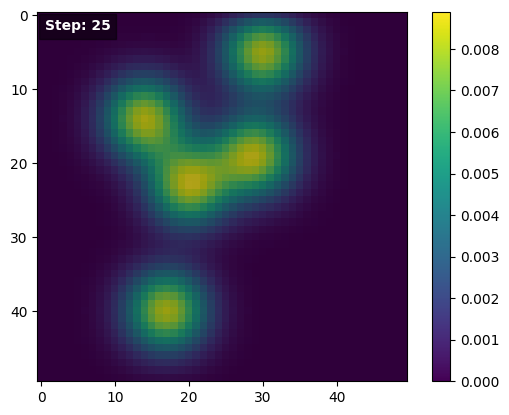

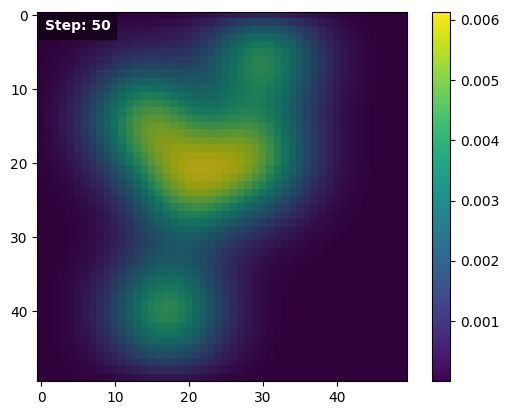

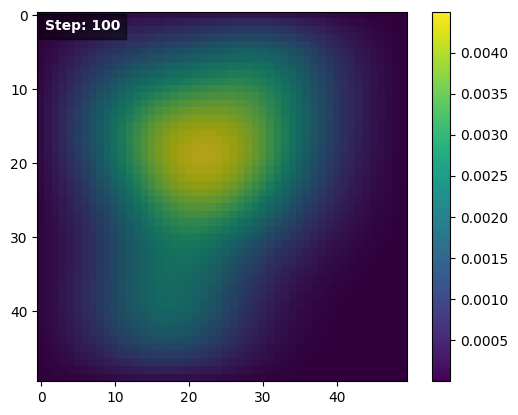

In [230]:
# Create animation and snapshot
createAnimation(automatonHistory, mask, filename='e1_diffusion_simulation')
simSnapshot(automatonHistory[25], 25, mask, filename='e1_diffusion_snapshot_25')
simSnapshot(automatonHistory[50], 50, mask, filename='e1_diffusion_snapshot_50')
simSnapshot(automatonHistory[100], 100, mask, filename='e1_diffusion_snapshot_100')

### Ejercicio 2

In [231]:
# Simulation parameters
M, N = 50, 50       # Grid dimensions
T = 100             # Number of time steps
Np = 10000          # Number of particles per simulation
K = 0.9             # Probability of moving
Nexp = 10           # Number of simulations to average over

# Define the mask for the L-shaped region
mask = np.ones((M, N), dtype=bool)

# Initial distribution u0
u_0 = np.zeros((M, N))
u_0[23, 20] = 1
u_0[14, 14] = 1
u_0[40, 17] = 1
u_0[19, 29] = 1
u_0[5, 30] = 1

In [232]:
particleHistory = particleSim(M, N, T, u_0, mask, Np, K)

In [233]:
createAnimation(particleHistory, mask, filename='e2_diffusion_simulation')

In [234]:
# Run the averaged particle simulation
avgParticleHistory = particleSimAverage(M, N, T, u_0, mask, Np, K, Nexp)

# Normalize the average to obtain probabilities
avgParticleHistory /= avgParticleHistory.sum(axis=(1, 2), keepdims=True)

In [235]:
createAnimation(avgParticleHistory, mask, filename='e2_diffusion_simulation_average')

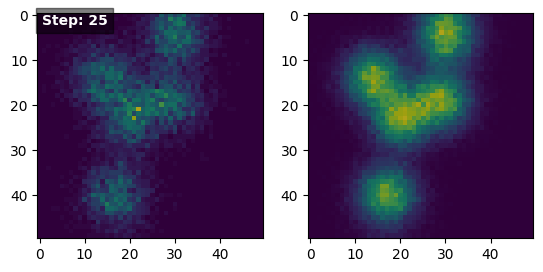

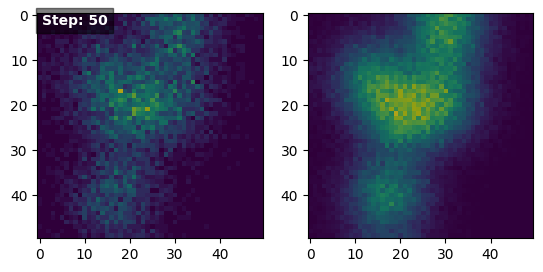

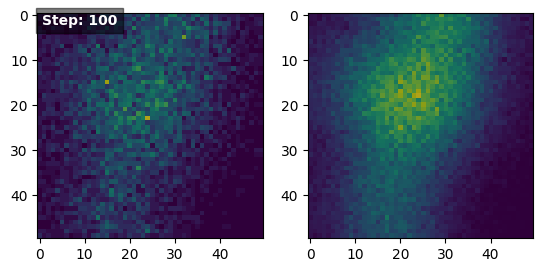

In [236]:
simCompareSnapshot(particleHistory[25], avgParticleHistory[25], 25, mask, mask, filename='e2_diffusion_snapshot_25')
simCompareSnapshot(particleHistory[50], avgParticleHistory[50], 50, mask, mask, filename='e2_diffusion_snapshot_50')
simCompareSnapshot(particleHistory[100], avgParticleHistory[100], 100, mask, mask, filename='e2_diffusion_snapshot_100')

### Ejercicio 3

#### Experimento 1: Variando K con la misma distribución inicial

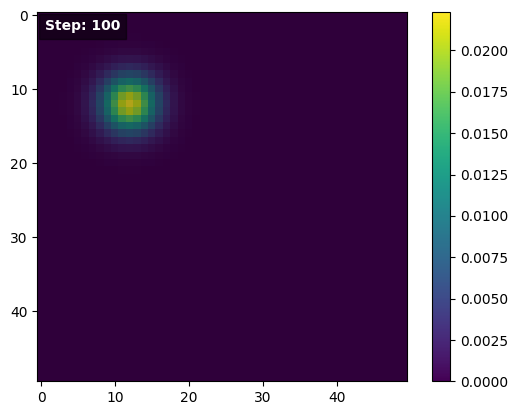

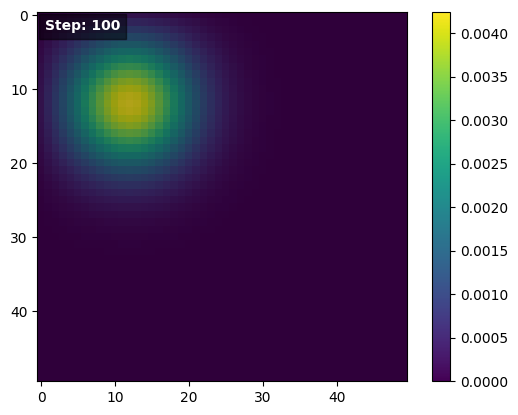

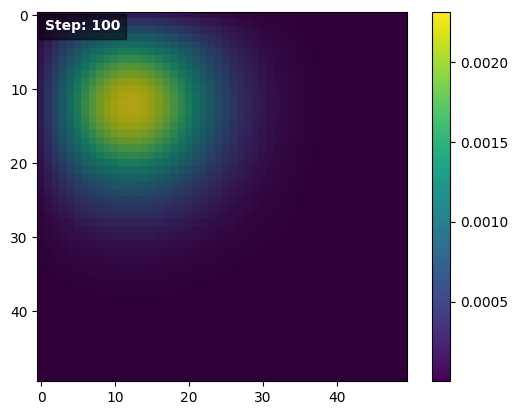

In [237]:
# Fixed initial distribution
u_0 = np.zeros((M, N))
u_0[M//4, N//4] = 1.0  # Initial concentration at a specific point
mask = np.ones((M, N), dtype=bool)

# Different values of K
K_values = [0.1, 0.5, 0.9]

for K in K_values:
    # Run automaton simulation
    history = automatonSim(M, N, T, u_0, K, mask)
    # Create snapshot at final time step
    K_str = str(K).replace('.', '_')
    simSnapshot(history[T], T, mask, filename=f'e3_e1_diffusion_snapshot_K_{K_str}')

#### Experimento 2: Variando la distribución inicial con el mismo K

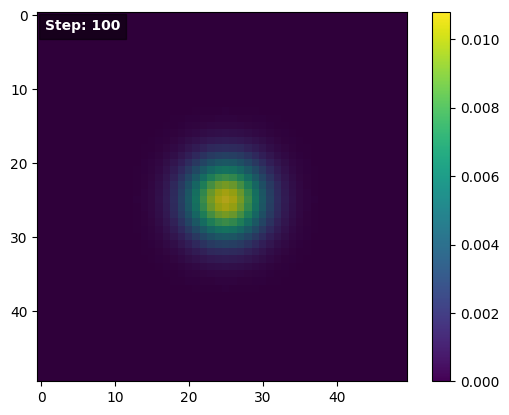

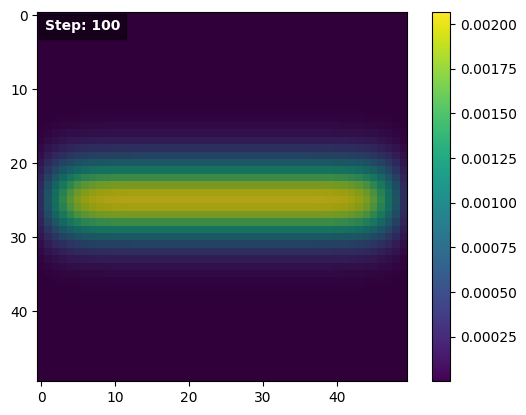

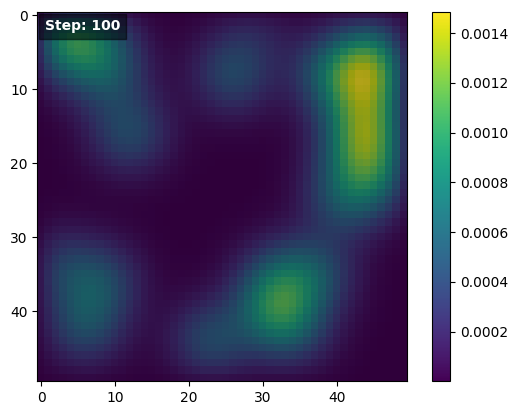

In [238]:
# Fixed diffusion coefficient
K = 0.2
mask = np.ones((M, N), dtype=bool)

# Different initial distributions
initial_distributions = {
    'Central Point': np.pad(np.ones((1, 1)), ((M//2, M - M//2 - 1), (N//2, N - N//2 - 1)), 'constant'),
    'Horizontal Line': np.pad(np.ones((1, N)), ((M//2, M - M//2 - 1), (0, 0)), 'constant'),
    'Random Spots': np.random.choice([0, 1], size=(M, N), p=[0.99, 0.01])
}

for name, u_0 in initial_distributions.items():
    # Normalize u_0 to sum to 1
    u_0 = u_0 / u_0.sum()
    # Run automaton simulation
    history = automatonSim(M, N, T, u_0, K, mask)
    # Create snapshot at final time step
    simSnapshot(history[T], T, mask, filename=f'e3_e2_diffusion_{name.replace(" ", "_")}')

#### Experimento 3: Distintas mascaras

In [239]:
def create_circular_mask(M, N, center=None, radius=None):
    if center is None:
        center = (int(M/2), int(N/2))
    if radius is None:
        radius = min(center[0], center[1], M-center[0], N-center[1])

    Y, X = np.ogrid[:M, :N]
    dist_from_center = np.sqrt((X - center[1])**2 + (Y - center[0])**2)

    mask = dist_from_center <= radius
    return mask

def create_cross_mask(M, N, thickness):
    mask = np.zeros((M, N), dtype=bool)
    center_x, center_y = M // 2, N // 2
    mask[center_x - thickness:center_x + thickness + 1, :] = True
    mask[:, center_y - thickness:center_y + thickness + 1] = True
    return mask

def create_triangle_mask(M, N, center, side_length):
    mask = np.zeros((M, N), dtype=bool)
    x, y = center
    half_side = side_length // 2
    for i in range(side_length):
        mask[x - i, y - half_side + i:y + half_side - i + 1] = True
    return mask

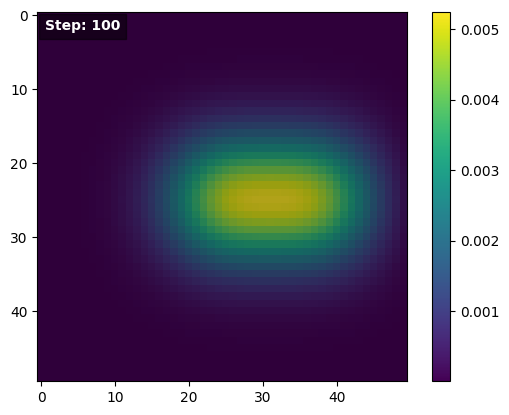

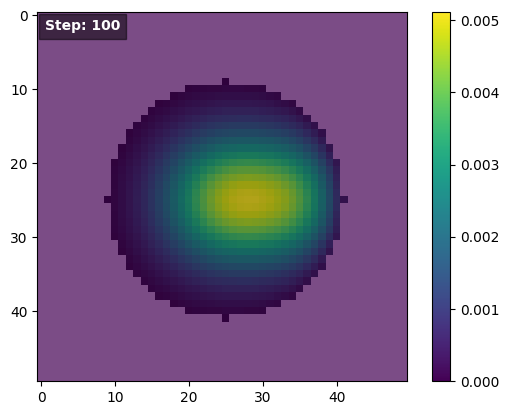

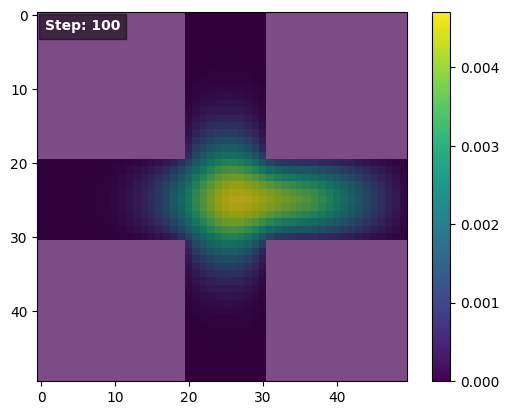

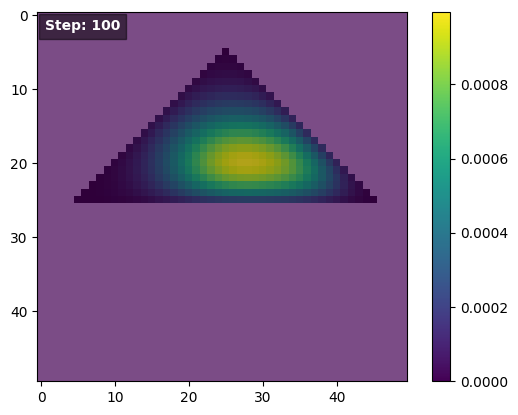

In [240]:
# Fixed initial distribution and K
u_0 = np.zeros((M, N))
u_0[M//2, N//2] = 1.0
# Center slightly right point
u_0[M//2, N//2 + N//4] = 1
K = 0.5
mask = np.ones((M, N), dtype=bool)

# Different masks
masks = {
    'L-Shaped': mask,
    'Circular': create_circular_mask(M, N, center=(M//2, N//2), radius=M//3),
    'Cross-Shaped': create_cross_mask(M, N, thickness=5),

    'Triangle': create_triangle_mask(M, N, center=(M//2, N//2), side_length=40),
}

for name, mask in masks.items():
    # Run automaton simulation
    history = automatonSim(M, N, T, u_0, K, mask)
    # Create snapshot at final time step
    simSnapshot(history[T], T, mask, filename=f'e3_e2_diffusion_{name}')